In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from tqdm.auto import tqdm

pd.set_option('display.float_format', str)

In [2]:
######### SPECIFY THE DATE_TIME OF THE RESULT FILES #########
model_dt_dicts = {
    'Syncan': {
        'TIL': '2024-07-19_09-29-18',
        'CANet': '2023-04-14_16-14-40'      # CANetW (h=5) results
    },
    'X-CANIDS': {
        'TIL': '2024-07-19_08-34-56',
        'CANet': '2024-06-30_19-10-20'      # nsig=107
    }
}

threshold_name = {
    'TIL': 'z_itv',
    'CANet': 'MSE'
}

print_name = {
    'TIL': 'TIL',
    'CANet': 'Rev. CANet',
    'Multimodal': '\sysname'
}

result_dir = '../../Results'

# Plotting ROC curves

In [6]:
import seaborn as sns
sns.color_palette('bright')

linestyles = [
    'solid',
    (0, (5, 4)),            # dashed
    (0, (1, 2)),            # dotted
    (0, (3, 3, 1, 3)),       # dashdotted
    (0, (3, 3, 1, 3, 1, 3)),    # dashdotdotted
]
plt.rcParams.update({'figure.dpi': 200, 'font.family': 'sans-serif', 'font.size': 18})

subfig_id = ['A', 'B', 'C', 'D']

n_sig='107'


Loading X-CANIDS TIL fuzz results:   0%|          | 0/17 [00:00<?, ?it/s]

Loading X-CANIDS TIL repl results:   0%|          | 0/4 [00:00<?, ?it/s]

Loading X-CANIDS TIL fabr results:   0%|          | 0/35 [00:00<?, ?it/s]

Loading X-CANIDS TIL susp results:   0%|          | 0/35 [00:00<?, ?it/s]

Loading X-CANIDS TIL masq results:   0%|          | 0/35 [00:00<?, ?it/s]

Loading X-CANIDS CANet fuzz results:   0%|          | 0/17 [00:00<?, ?it/s]

Loading X-CANIDS CANet repl results:   0%|          | 0/4 [00:00<?, ?it/s]

Loading X-CANIDS CANet fabr results:   0%|          | 0/35 [00:00<?, ?it/s]

Loading X-CANIDS CANet susp results:   0%|          | 0/35 [00:00<?, ?it/s]

Loading X-CANIDS CANet masq results:   0%|          | 0/35 [00:00<?, ?it/s]

Loading Syncan TIL results:   0%|          | 0/5 [00:00<?, ?it/s]

Loading Syncan CANet results:   0%|          | 0/5 [00:00<?, ?it/s]

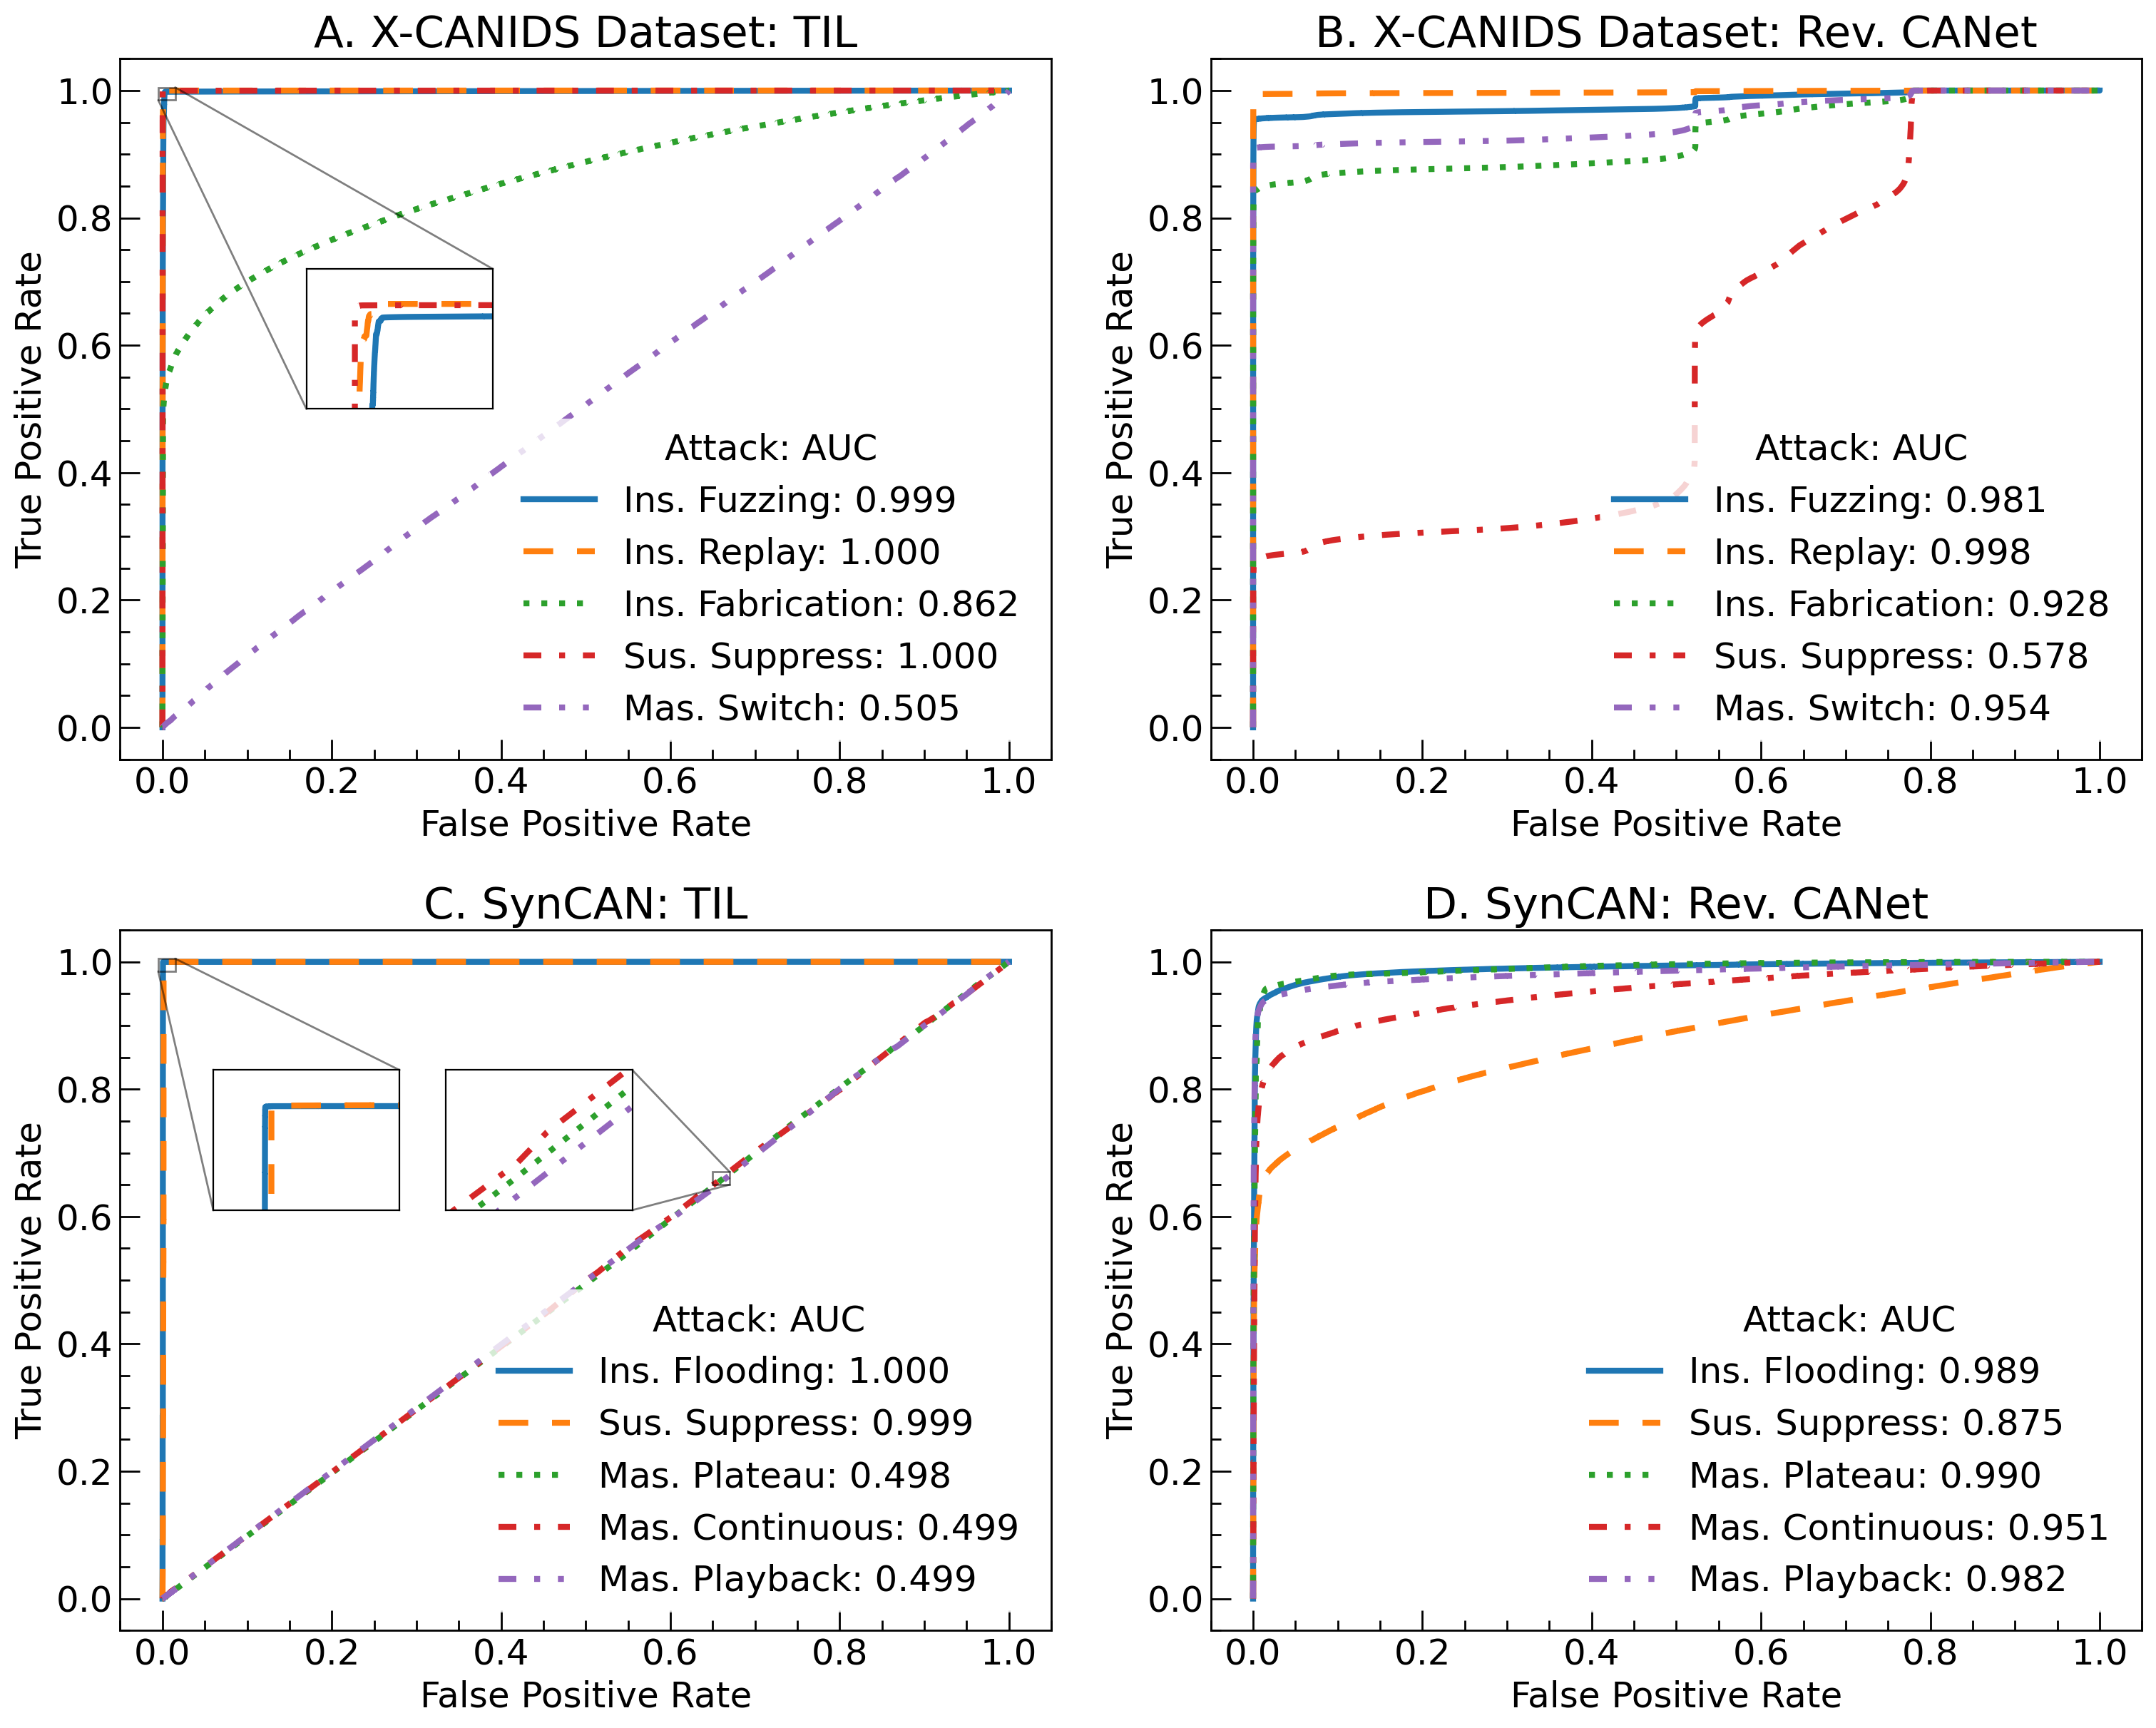

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12), layout='constrained')
fig.get_layout_engine().set(wspace=0.05, hspace=0.05)

####################
DATASET = 'X-CANIDS'
model_dt_dict = model_dt_dicts[DATASET]
attack_map_dict = {'fuzz': 'Ins. Fuzzing', 'repl': 'Ins. Replay', 'fabr': 'Ins. Fabrication', 'susp': 'Sus. Suppress', 'masq': 'Mas. Switch'}
a_result_file = [
    x for x in Path(result_dir).iterdir()
    if DATASET in x.name and 'CANet' in x.name and model_dt_dict['CANet'] in x.name
][0].name
n_sig = a_result_file.split('_')[2][3:]

row, col = 0, 0
for m, t in model_dt_dict.items():
    axs[row, col].set_title(f'{subfig_id[2*row+col]}. X-CANIDS Dataset: {print_name[m]}', fontsize=22)
    i = 0
    if m == 'TIL':
        # set zoom inset plot 1
        zoom_area=[0.2, 0.5, 0.2, 0.2]  # [x1, y1, width, height]
        axins1 = axs[row, col].inset_axes(zoom_area, xlim=(-0.005, 0.015), ylim=(0.985, 1.005), xticklabels=[], yticklabels=[])
        axins1.set_xticks([]), axins1.set_yticks([])
        axs[row, col].indicate_inset_zoom(axins1, edgecolor='black')
    for attack, attack_print_name in attack_map_dict.items():
        if m == 'TIL':
            result_files = Path(result_dir).glob(f'{DATASET}_{m}_{t}_{attack}-*.parquet')
        elif m == 'CANet':
            result_files = Path(result_dir).glob(f'{DATASET}_{m}_sig{n_sig}_{t}_{attack}-*.parquet')
        dfs = []
        for result_file in tqdm(list(result_files), desc=f'Loading {DATASET} {m} {attack} results'):
            df = pd.read_parquet(result_file)
            if m == 'TIL':  # sorting opposite to use scikit-learn roc_curve()
                df[threshold_name[m]] = (df[threshold_name[m]] - 1).abs()
            dfs.append(df[[threshold_name[m], 'Session']])
        df_all = pd.concat(dfs, axis='index')
        fpr, tpr, thresholds = metrics.roc_curve(df_all['Session'], df_all[threshold_name[m]])
        auc = metrics.auc(fpr, tpr)
        roccurve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f'{attack_map_dict[attack]}: {auc:.3f}')
        roccurve.plot(ax=axs[row, col], linewidth=3, linestyle=linestyles[i])
        if m == 'TIL':
            axins1.plot(fpr, tpr, linewidth=3, linestyle=linestyles[i])
        i += 1
    col += 1

####################
DATASET = 'Syncan'
model_dt_dict = model_dt_dicts[DATASET]
attacks = ['flooding', 'suppress', 'plateau', 'continuous', 'playback']
attack_map_dict = {'flooding': 'Ins. Flooding', 'suppress': 'Sus. Suppress', 
                   'plateau': 'Mas. Plateau', 'continuous': 'Mas. Continuous', 'playback': 'Mas. Playback'}

row += 1
col = 0
for m, t in model_dt_dict.items():
    axs[row, col].set_title(f'{subfig_id[2*row+col]}. SynCAN: {print_name[m]}', fontsize=22)
    if m == 'TIL':
        # set zoom inset plot 2
        zoom_area=[0.1, 0.6, 0.2, 0.2]  # [x1, y1, width, height]
        axins2 = axs[row, col].inset_axes(zoom_area, xlim=(-0.005, 0.015), ylim=(0.985, 1.005), xticklabels=[], yticklabels=[])
        axins2.set_xticks([]), axins2.set_yticks([])
        axs[row, col].indicate_inset_zoom(axins2, edgecolor='black')
        # set zoom inset plot 3
        zoom_area=[0.35, 0.6, 0.2, 0.2]  # [x1, y1, width, height]
        axins3 = axs[row, col].inset_axes(zoom_area, xlim=(0.65, 0.67), ylim=(0.65, 0.67), xticklabels=[], yticklabels=[])
        axins3.set_xticks([]), axins3.set_yticks([])
        axs[row, col].indicate_inset_zoom(axins3, edgecolor='black')
    for i, attack in enumerate(tqdm(attacks, desc=f'Loading {DATASET} {m} results')):
        if m == 'TIL':
            result_file = f'../../Results/{DATASET}_{m}_{t}_{attack}.parquet'
        else:
            result_file = f'../../Results/{DATASET}_{m}_{t}_{attack}.csv'
        if Path(result_file).exists():
            if m == 'TIL':  # sorting opposite to use scikit-learn roc_curve()
                df = pd.read_parquet(result_file)
                df[threshold_name[m]] = (df[threshold_name[m]] - 1).abs()
            else:
                df = pd.read_csv(result_file)
            fpr, tpr, thresholds = metrics.roc_curve(df['Session'], df[threshold_name[m]])
            auc = metrics.auc(fpr, tpr)
            roccurve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f'{attack_map_dict[attack]}: {auc:.3f}')
            roccurve.plot(ax=axs[row, col], linewidth=3, linestyle=linestyles[i])
            if m == 'TIL':
                axins2.plot(fpr, tpr, linewidth=3, linestyle=linestyles[i])
                axins3.plot(fpr, tpr, linewidth=3, linestyle=linestyles[i])
        else:
            print(f'No result file for {DATASET} dataset and {m} model. (Attack: {attack})')
    col += 1

####################
for ax in axs.ravel():
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.tick_params(which='major', direction='in', length=10, width=1, labelsize=18)
    ax.tick_params(which='minor', direction='in', length=5, width=1, labelsize=18)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
    if ax.get_legend():
        ax.get_legend().get_frame().set_linewidth(0)
        ax.get_legend().set_title('Attack: AUC')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('auto')  # automatic scaling for x- and y-axis (not equally)

# plt.subplots_adjust(wspace=7)
# plt.tight_layout()
plt.savefig('ROC plot.pdf', bbox_inches = "tight")
plt.show()

# Calculating evaluation metrics

In [11]:
# Calculates the confusion matix, TPR, and TNR
def evaluation(real_labels, predicted_labels, print_matrix=False, print_metrics=True):
    assert len(real_labels) == len(predicted_labels), 'Inputs must have same length.'
    cm_data = metrics.confusion_matrix(real_labels, predicted_labels, labels=[0, 1])
    tn, fp, fn, tp = cm_data.ravel()
    cm = pd.DataFrame(cm_data, index=pd.MultiIndex.from_tuples([('Real', 0), ('Real', 1)]), columns=pd.MultiIndex.from_tuples([('Predicted', 0), ('Predicted', 1)]))
    if print_matrix:
        print(cm)
    tnr = tn / (tn + fp)
    if tp + fn == 0:
        tpr = None
        f1 = None
        if print_metrics:
            print(f'TPR = N/A, TNR = {tnr:.3f}, F1 = N/A')
    else:
        tpr = tp / (tp + fn)
        f1 = (2 * tp) / (2 * tp + fp + fn)
        if print_metrics:
            print(f'TPR = {tpr:.3f}, TNR = {tnr:.3f}, F1 = {f1:.3f}')
    return cm_data, tpr, tnr, f1

eval_results = {}

### Dataset: X-CANIDS Dataset

In [12]:
# Set thresholds
d = 'X-CANIDS'
threshold_dict = {
    'Itv': dict(),
    'CANet': dict()
}
quantiles = {
    'Itv': 0.001,
    'CANet': 0.9999
}
n_sig = '107'
for m in threshold_dict.keys():
    if m == 'Itv':
        thres_col = 'z_itv'
        t = model_dt_dicts[d]['TIL']
        valid_file = f'{result_dir}/{d}_TIL_{t}_valid.parquet'
        debiations = pd.read_parquet(valid_file)[thres_col]
        threshold_dict[m] = np.quantile(debiations, quantiles[m])
    elif m == 'CANet':
        t = model_dt_dicts[d][m]
        valid_file = f'{result_dir}/{d}_{m}_sig{n_sig}_{t}_valid.csv'
        debiations = pd.read_csv(valid_file)[threshold_name[m]]
        threshold_dict[m] = np.quantile(debiations, quantiles[m])
    print(f'[{m}] Quantile={quantiles[m]}, Threshold={threshold_dict[m]}')

[Itv] Quantile=0.001, Threshold=0.999441527222617
[CANet] Quantile=0.9999, Threshold=0.00010109362220692199


In [13]:
DATASET = 'X-CANIDS'
attack_map_dict = {'fabr': 'Fabrication', 'fuzz': 'Fuzzing', 'masq': 'Masquerade', 'repl': 'Replay', 'susp': 'Suspension'}
attacks = attack_map_dict.keys()
merge_predictions = dict()
eval_results[DATASET] = {'TIL': {a: dict() for a in attacks},
                         'CANet': {a: dict() for a in attacks},
                         'Multimodal': {a: dict() for a in attacks}}

# In case of X-CANIDS Dataset, we have to calculate results of each dataset file and get the macro-average

# Evaluation results of individual models
# TIL
for attack, attack_print_name in attack_map_dict.items():
    t = model_dt_dicts[DATASET]['TIL']
    result_files = Path(result_dir).glob(f'{DATASET}_TIL_{t}_{attack}-*.parquet')
    for result_file in tqdm(list(result_files), desc=f'Loading {DATASET} TIL {attack} results'):
        param = result_file.stem.split('_')[-1].split('-')[1]
        df = pd.read_parquet(result_file)
        df['TIL'] = 0
        df.loc[df['z_itv'] < threshold_dict['Itv'], 'TIL'] = 1   # log likelihood (smaller is worse)
        if (attack, param) not in merge_predictions.keys():
            merge_predictions[(attack, param)] = list()
        df.sort_values(by='Time', inplace=True)
        merge_predictions[(attack, param)].append(df[['Time', 'Session', 'TIL']].copy())

# CANet
for attack, attack_print_name in attack_map_dict.items():
    t = model_dt_dicts[DATASET]['CANet']
    result_files = Path(result_dir).glob(f'{DATASET}_CANet_sig{n_sig}_{t}_{attack}-*.parquet')
    for result_file in tqdm(list(result_files), desc=f'Loading {DATASET} CANet {attack} results'):
        param = result_file.stem.split('_')[-1].split('-')[1]
        df = pd.read_parquet(result_file)
        df['CANet'] = 0
        df.loc[df[threshold_name['CANet']] >= threshold_dict['CANet'], 'CANet'] = 1  # reconstruction error (bigger is worse)
        # _, tpr, tnr, f1 = evaluation(df['Session'], df['CANet'], print_metrics=False)
        # eval_results[DATASET]['CANet'][attack][param] = {'TPR': tpr, 'TNR': tnr, 'F1': f1}
        if (attack, param) not in merge_predictions.keys():
            merge_predictions[(attack, param)] = list()
        merge_predictions[(attack, param)].append(df[['Time', 'Session', 'CANet']].copy())

# Evaluation results of the multimodal model
for (attack, param), df_list in tqdm(merge_predictions.items(), desc='Merging the results'):
    df_merged = pd.merge_asof(df_list[0], df_list[1], on='Time', suffixes=('_x', '_y'), tolerance=0.0000001)
    df_merged.dropna(inplace=True)
    df_merged['Multimodal'] = df_merged[['TIL', 'CANet']].max(axis=1)
    _, tpr, tnr, f1 = evaluation(df_merged['Session_y'], df_merged['TIL'], print_metrics=False)
    eval_results[DATASET]['TIL'][attack][param] = {'TPR': tpr, 'TNR': tnr, 'F1': f1}
    _, tpr, tnr, f1 = evaluation(df_merged['Session_y'], df_merged['CANet'], print_metrics=False)
    eval_results[DATASET]['CANet'][attack][param] = {'TPR': tpr, 'TNR': tnr, 'F1': f1}
    # _, tpr, tnr, f1 = evaluation(df_merged['Session_x'], df_merged['Multimodal'], print_metrics=False)
    _, tpr, tnr, f1 = evaluation(df_merged['Session_y'], df_merged['Multimodal'], print_metrics=False)
    eval_results[DATASET]['Multimodal'][attack][param] = {'TPR': tpr, 'TNR': tnr, 'F1': f1}

# print results
for m, mdata in eval_results[DATASET].items():
    for attack, adata in mdata.items():
        tprs, tnrs, f1s = list(), list(), list()
        for param, pdata in adata.items():
            tprs.append(pdata['TPR'])
            tnrs.append(pdata['TNR'])
            f1s.append(pdata['F1'])
        avg_tpr = np.average(tprs)
        avg_tnr = np.average(tnrs)
        avg_f1 = np.average(f1s)
        print(f'{m=} {attack=} {avg_tpr=:.4f} {avg_tnr=:.4f} {avg_f1=:.4f}')

Loading X-CANIDS TIL fabr results:   0%|          | 0/35 [00:00<?, ?it/s]

Loading X-CANIDS TIL fuzz results:   0%|          | 0/17 [00:00<?, ?it/s]

Loading X-CANIDS TIL masq results:   0%|          | 0/35 [00:00<?, ?it/s]

Loading X-CANIDS TIL repl results:   0%|          | 0/4 [00:00<?, ?it/s]

Loading X-CANIDS TIL susp results:   0%|          | 0/35 [00:00<?, ?it/s]

Loading X-CANIDS CANet fabr results:   0%|          | 0/35 [00:00<?, ?it/s]

Loading X-CANIDS CANet fuzz results:   0%|          | 0/17 [00:00<?, ?it/s]

Loading X-CANIDS CANet masq results:   0%|          | 0/35 [00:00<?, ?it/s]

Loading X-CANIDS CANet repl results:   0%|          | 0/4 [00:00<?, ?it/s]

Loading X-CANIDS CANet susp results:   0%|          | 0/35 [00:00<?, ?it/s]

Merging the results:   0%|          | 0/126 [00:00<?, ?it/s]

m='TIL' attack='fabr' avg_tpr=0.5109 avg_tnr=0.9985 avg_f1=0.6103
m='TIL' attack='fuzz' avg_tpr=0.9978 avg_tnr=0.9959 avg_f1=0.9970
m='TIL' attack='masq' avg_tpr=0.0018 avg_tnr=0.9985 avg_f1=0.0037
m='TIL' attack='repl' avg_tpr=1.0000 avg_tnr=0.9955 avg_f1=0.9988
m='TIL' attack='susp' avg_tpr=0.9998 avg_tnr=0.9984 avg_f1=0.9991
m='CANet' attack='fabr' avg_tpr=0.8111 avg_tnr=0.9996 avg_f1=0.8640
m='CANet' attack='fuzz' avg_tpr=0.9399 avg_tnr=0.9992 avg_f1=0.9619
m='CANet' attack='masq' avg_tpr=0.9002 avg_tnr=0.9997 avg_f1=0.9222
m='CANet' attack='repl' avg_tpr=0.9913 avg_tnr=0.9995 avg_f1=0.9955
m='CANet' attack='susp' avg_tpr=0.2299 avg_tnr=0.9997 avg_f1=0.2923
m='Multimodal' attack='fabr' avg_tpr=0.9000 avg_tnr=0.9981 avg_f1=0.9400
m='Multimodal' attack='fuzz' avg_tpr=0.9985 avg_tnr=0.9956 avg_f1=0.9972
m='Multimodal' attack='masq' avg_tpr=0.9004 avg_tnr=0.9982 avg_f1=0.9217
m='Multimodal' attack='repl' avg_tpr=1.0000 avg_tnr=0.9953 avg_f1=0.9987
m='Multimodal' attack='susp' avg_tpr=0

In [14]:
# print results
for m, mdata in eval_results['X-CANIDS'].items():
    avg_tprs, avg_tnrs, avg_f1s = list(), list(), list()
    for attack, adata in mdata.items():
        tprs, tnrs, f1s = list(), list(), list()
        for param, pdata in adata.items():
            tprs.append(pdata['TPR'])
            tnrs.append(pdata['TNR'])
            f1s.append(pdata['F1'])
        avg_tprs.append(np.average(tprs))
        avg_tnrs.append(np.average(tnrs))
        avg_f1s.append(np.average(f1s))
    total_avg_tpr = np.average(avg_tprs)
    total_avg_tnr = np.average(avg_tnrs)
    total_avg_f1 = np.average(avg_f1s)
    print(f'{m=} {total_avg_tpr=:.3f} {total_avg_tnr=:.3f} {total_avg_f1=:.3f}')

m='TIL' total_avg_tpr=0.702 total_avg_tnr=0.997 total_avg_f1=0.722
m='CANet' total_avg_tpr=0.774 total_avg_tnr=1.000 total_avg_f1=0.807
m='Multimodal' total_avg_tpr=0.960 total_avg_tnr=0.997 total_avg_f1=0.971


In [15]:
import gc
del merge_predictions, df_merged
gc.collect()

12246

### Dataset: SynCAN

In [16]:
# Set thresholds
d = 'Syncan'
threshold_dict = {
    'Itv': dict(),
    'CANet': dict()
}
quantiles = {
    'Itv': 0.0001,
    'CANet': 0.999
}
for m in threshold_dict.keys():
    if m == 'Itv':
        thres_col = 'z_itv'
        t = model_dt_dicts[d]['TIL']
        valid_file = f'{result_dir}/{d}_TIL_{t}_valid.parquet'
        debiations = pd.read_parquet(valid_file)[thres_col]
        threshold_dict[m] = np.quantile(debiations, quantiles[m])
    elif m == 'CANet':
        t = model_dt_dicts[d][m]
        valid_file = f'{result_dir}/{d}_{m}_{t}_valid.csv'
        debiations = pd.read_csv(valid_file)[threshold_name[m]]
        threshold_dict[m] = np.quantile(debiations, quantiles[m])
    print(f'[{m}] Quantile={quantiles[m]}, Threshold={threshold_dict[m]}')

[Itv] Quantile=0.0001, Threshold=0.9960287566747446
[CANet] Quantile=0.999, Threshold=5.5026256140998275e-06


In [17]:
DATASET = 'Syncan'
model_dt_dict = model_dt_dicts[DATASET]
attacks = ['normal', 'flooding', 'suppress', 'plateau', 'continuous', 'playback']
merge_predictions = {a: [] for a in attacks}
eval_results[DATASET] = {'TIL': {a: dict() for a in attacks},
                         'CANet': {a: dict() for a in attacks},
                         'Multimodal': {a: dict() for a in attacks}}

# Evaluation results of individual models
# TIL
for attack in tqdm(attacks, desc=f'Loading {DATASET} TIL results'):
    t = model_dt_dict['TIL']
    result_file = f'{result_dir}/{DATASET}_TIL_{t}_{attack}.parquet'
    df = pd.read_parquet(result_file)
    df['TIL'] = 0
    df.loc[df['z_itv'] < threshold_dict['Itv'], 'TIL'] = 1   # log likelihood (smaller is worse)
    df.sort_values(by='Time', inplace=True)
    merge_predictions[attack].append(df[['Time', 'Session', 'TIL']].copy())

# CANet
for attack in tqdm(attacks, desc=f'Loading {DATASET} CANet results'):
    t = model_dt_dict['CANet']
    result_file = f'{result_dir}/{DATASET}_CANet_{t}_{attack}.csv'
    df = pd.read_csv(result_file)
    df['CANet'] = 0
    df.loc[df[threshold_name['CANet']] >= threshold_dict['CANet'], 'CANet'] = 1  # reconstruction error (bigger is worse)
    merge_predictions[attack].append(df[['Time', 'Session', 'CANet']].copy())

# Evaluation results of the multimodal model
for attack, df_list in tqdm(merge_predictions.items(), desc='Merging the results'):
    df1 = df_list[0]
    df2 = df_list[1]
    t_start = max(df1['Time'].iloc[0], df2['Time'].iloc[0])
    t_end = min(df1['Time'].iloc[-1], df2['Time'].iloc[-1])
    df1 = df1.query(f'{t_start} <= Time <= {t_end}').reset_index(drop=True)
    df2 = df2.query(f'{t_start} <= Time <= {t_end}').reset_index(drop=True)
    df_merged = pd.merge(df1, df2, left_index=True, right_index=True)
    assert len(df_merged) == min(len(merge_predictions[attack][0]), len(merge_predictions[attack][1])), "Two model results haven't merged properly."
    df_merged['Multimodal'] = df_merged[list(model_dt_dict.keys())].max(axis=1)
    _, tpr, tnr, f1 = evaluation(df_merged['Session_y'], df_merged['TIL'], print_metrics=False)
    eval_results[DATASET]['TIL'][attack] = {'TPR': tpr, 'TNR': tnr, 'F1': f1}
    _, tpr, tnr, f1 = evaluation(df_merged['Session_y'], df_merged['CANet'], print_metrics=False)
    eval_results[DATASET]['CANet'][attack] = {'TPR': tpr, 'TNR': tnr, 'F1': f1}
    _, tpr, tnr, f1 = evaluation(df_merged['Session_y'], df_merged['Multimodal'], print_metrics=False)
    eval_results[DATASET]['Multimodal'][attack] = {'TPR': tpr, 'TNR': tnr, 'F1': f1}

# print results
for m, mdata in eval_results[DATASET].items():
    for attack, adata in mdata.items():
        tpr = adata['TPR']
        tnr = adata['TNR']
        f1 = adata['F1']
        if attack == 'normal':
            print(f'{m=} {attack=} {tpr=} {tnr=:.4f} {f1=}')
        else:
            print(f'{m=} {attack=} {tpr=:.4f} {tnr=:.4f} {f1=:.4f}')

Loading Syncan TIL results:   0%|          | 0/6 [00:00<?, ?it/s]

Loading Syncan CANet results:   0%|          | 0/6 [00:00<?, ?it/s]

Merging the results:   0%|          | 0/6 [00:00<?, ?it/s]

m='TIL' attack='normal' tpr=None tnr=0.9999 f1=None
m='TIL' attack='flooding' tpr=0.9998 tnr=0.9991 f1=0.9989
m='TIL' attack='suppress' tpr=0.9997 tnr=0.9987 f1=0.9964
m='TIL' attack='plateau' tpr=0.0001 tnr=0.9999 f1=0.0002
m='TIL' attack='continuous' tpr=0.0002 tnr=0.9999 f1=0.0004
m='TIL' attack='playback' tpr=0.0000 tnr=0.9999 f1=0.0000
m='CANet' attack='normal' tpr=None tnr=0.9981 f1=None
m='CANet' attack='flooding' tpr=0.8989 tnr=0.9961 f1=0.9423
m='CANet' attack='suppress' tpr=0.5883 tnr=0.9962 f1=0.7317
m='CANet' attack='plateau' tpr=0.9167 tnr=0.9933 f1=0.9396
m='CANet' attack='continuous' tpr=0.7508 tnr=0.9948 f1=0.8415
m='CANet' attack='playback' tpr=0.8921 tnr=0.9965 f1=0.9317
m='Multimodal' attack='normal' tpr=None tnr=0.9980 f1=None
m='Multimodal' attack='flooding' tpr=0.9998 tnr=0.9959 f1=0.9952
m='Multimodal' attack='suppress' tpr=0.9997 tnr=0.9957 f1=0.9890
m='Multimodal' attack='plateau' tpr=0.9167 tnr=0.9931 f1=0.9393
m='Multimodal' attack='continuous' tpr=0.7508 tnr

In [18]:
for m, mdata in eval_results['Syncan'].items():
    tprs, tnrs, f1s = list(), list(), list()
    for attack, adata in mdata.items():
        tprs.append(adata['TPR'])
        tnrs.append(adata['TNR'])
        f1s.append(adata['F1'])
    total_avg_tpr = np.average([x for x in tprs if x is not None])
    total_avg_tnr = np.average([x for x in tnrs if x is not None])
    total_avg_f1 = np.average([x for x in f1s if x is not None])
    print(f'{m=} {total_avg_tpr=:.3f} {total_avg_tnr=:.3f} {total_avg_f1=:.3f}')

m='TIL' total_avg_tpr=0.400 total_avg_tnr=1.000 total_avg_f1=0.399
m='CANet' total_avg_tpr=0.809 total_avg_tnr=0.996 total_avg_f1=0.877
m='Multimodal' total_avg_tpr=0.912 total_avg_tnr=0.996 total_avg_f1=0.939


In [36]:
# Submission version
attacks = ['normal', 'flooding', 'suppress', 'plateau', 'continuous', 'playback']
merge_predictions = {a: [] for a in attacks}
eval_results[DATASET] = {'Itv': {a: None for a in attacks},
                         'CANet': {a: None for a in attacks},
                         'Multimodal': {a: None for a in attacks}}

# Evaluation results of individual models
for m, t in model_dt_dict.items():
    print(f'****** {DATASET}: {m} ******')
    best_threshold = threshold_dict[DATASET][m]
    for attack in attacks:
        print(f'[Class: {attack}]')
        result_file = f'../../Results/{DATASET}_{m}_{t}_{attack}.csv'
        df = pd.read_csv(result_file)
        df[m] = 0
        if m == 'Itv':
            df.loc[df[threshold_name[m]] < best_threshold, m] = 1   # log likelihood (smaller is worse)
        else:
            df.loc[df[threshold_name[m]] >= best_threshold, m] = 1  # reconstruction error (bigger is worse)
        _, tpr, tnr, f1 = evaluation(df['Session'], df[m])
        eval_results[DATASET][m][attack] = {'TPR': tpr, 'TNR': tnr, 'F1': f1}
        merge_predictions[attack].append(df[['Time', 'Session', m]].copy())
    print('')

# Evaluation results of the multimodal model
print(f'****** {DATASET}: Multimodal ******')
for attack in attacks:
    print(f'[Class: {attack}]')
    df1 = merge_predictions[attack][0]
    df2 = merge_predictions[attack][1]
    t_start = max(df1['Time'].iloc[0], df2['Time'].iloc[0])
    t_end = min(df1['Time'].iloc[-1], df2['Time'].iloc[-1])
    df1 = df1.query(f'{t_start} <= Time <= {t_end}').reset_index(drop=True)
    df2 = df2.query(f'{t_start} <= Time <= {t_end}').reset_index(drop=True)
    df_merged = pd.merge(df1, df2, left_index=True, right_index=True)
    assert len(df_merged) == min(len(merge_predictions[attack][0]), len(merge_predictions[attack][1])), "Two model reuslts haven't merged properly."
    df_merged['Multimodal'] = df_merged[list(model_dt_dict.keys())].max(axis=1)
    _, tpr, tnr, f1 = evaluation(df_merged['Session_x'], df_merged['Multimodal'])
    eval_results[DATASET]['Multimodal'][attack] = {'TPR': tpr, 'TNR': tnr, 'F1': f1}

****** Syncan: Itv ******
[Class: normal]
TPR = N/A, TNR = 0.999, F1 = N/A
[Class: flooding]
TPR = 0.997, TNR = 0.999, F1 = 0.997
[Class: suppress]
TPR = 0.994, TNR = 0.999, F1 = 0.995
[Class: plateau]
TPR = 0.001, TNR = 0.999, F1 = 0.001
[Class: continuous]
TPR = 0.001, TNR = 0.999, F1 = 0.002
[Class: playback]
TPR = 0.001, TNR = 0.999, F1 = 0.002

****** Syncan: CANet ******
[Class: normal]
TPR = N/A, TNR = 0.998, F1 = N/A
[Class: flooding]
TPR = 0.899, TNR = 0.996, F1 = 0.942
[Class: suppress]
TPR = 0.588, TNR = 0.996, F1 = 0.732
[Class: plateau]
TPR = 0.917, TNR = 0.993, F1 = 0.940
[Class: continuous]
TPR = 0.751, TNR = 0.995, F1 = 0.842
[Class: playback]
TPR = 0.892, TNR = 0.997, F1 = 0.932

****** Syncan: Multimodal ******
[Class: normal]
TPR = N/A, TNR = 0.997, F1 = N/A
[Class: flooding]
TPR = 0.999, TNR = 0.997, F1 = 0.996
[Class: suppress]
TPR = 0.996, TNR = 0.996, F1 = 0.989
[Class: plateau]
TPR = 0.916, TNR = 0.994, F1 = 0.941
[Class: continuous]
TPR = 0.753, TNR = 0.995, F1